In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import psycopg2
import sqlalchemy as sa
import datetime
from datetime import timedelta,datetime 
from dateutil.relativedelta import relativedelta
from sklearn.cluster import KMeans
import warnings 

from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import kstest, norm  ,shapiro 

# import sys
# import os
# sys.path.append(os.path.abspath("../"))
# #from recsys import *
# #from generic_preprocessing import *
# from IPython.display import HTML

### Check normal distributed data 

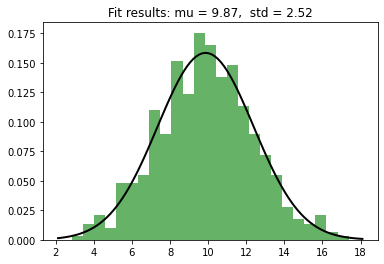

In [2]:



# Generate some data for this demonstration.
data = norm.rvs(10.0, 2.5, size=500)

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

## our  data

In [39]:
df=pd.read_csv('GM battary service campaign2.csv')

In [40]:
df['spending']=df['trx'] * 500

In [41]:
df.dtypes

customer_magic     int64
vehicle_magic      int64
segment           object
mobile             int64
emailadd          object
max_date          object
trx                int64
pref_lang         object
spending           int64
dtype: object

In [45]:
#%debug
crd=pd.read_csv('../../credental.csv')
rfm=RFM(crd,1,'test.csv',None)
d=rfm.RFM_calc()
d


TypeError: 'module' object is not callable

In [ ]:
# Fit a normal distribution to the data:
mu_df, std_df = norm.fit(df['trx'])

# Plot the histogram.
plt.hist(df['trx'], bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_df, std_df)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu_df, std_df)
plt.title(title)

plt.show()

### Kolmogorov Smirnov test

In [ ]:

def Kolmogorov_test(df):
    ks_statistic, p_value = kstest(df, 'norm')
    print(ks_statistic, p_value)
    if p_value <0.05:
        print("reject H0 that distribution is normal") #not normal
    else:
        print("can't reject H0 that distribution is normal") # normal

## Lilliefors test

In [ ]:
#If the P-Value of the Lilliefors Test is larger than 0.05, we assume a normal distribution
def Lilliefors_test(df):
    ksstat,p=lilliefors(df)

    if p <0.05:
        print("reject H0 that distribution is normal") #not normal
    else:
        print("can't reject H0 that distribution is normal") # normal

## Shapiro Wilk test

In [ ]:
#Shapiro Wilk normal distribution test
#If the P-Value of the Shapiro Wilk Test is larger than 0.05, we assume a normal distribution p-value may not be accurate for N > 5000
def shapiro_test(df):
    stat, p=shapiro(df)
    if p <0.05:
            print("reject H0 that distribution is normal") #not normal
    else:
        print("can't reject H0 that distribution is normal") # normal


In [ ]:
Kolmogorov_test(df.trx)

In [ ]:
Kolmogorov_test(data)

In [ ]:
# !pip3 uninstall statsmodels --yes
# !pip3 install numpy scipy patsy pandas
# !pip3 install statsmodels

In [ ]:
Lilliefors_test(df.trx)

In [ ]:
Lilliefors_test(data)

In [ ]:
shapiro_test(df.trx)

In [ ]:
shapiro_test(data)

# Sampling methods

1- Random Sampling

In [ ]:
def random_sampling(df,population_count):
    sample_count=population_count*.1
    random_sample=df.sample(int(sample_count))
    return random_sample
    

2- systematic sampling

In [ ]:
def systematic_sampling(df, step):
    indexes = np.arange(0, len(df), step=step)
    systematic_sample = df.iloc[indexes]
    return systematic_sample

### you can also use RFM to segment your customers then use starified sampling to get even sample from each cluster

In [42]:
class RFM:
    def __init__(self, crd,is_csv,csv_file=None,sql_query=None):
        self.crd=crd
        self.is_csv=is_csv
        if is_csv==1:
            self.csv_file=csv_file
        else:
            self.sql_query=sql_query
    def connect(self):
        redshift = psycopg2.connect(host=crd['server'][0],
                                    database=crd['DB'][0], 
                                    user=crd['User'][0], 
                                    password=crd['Password'][0],
                                    port=crd['Port'][0]
                                   )
        print('Connection successful')
        return redshift
    
    def getdata(self,sqlText):
        redshift=self.connect()
        df=pd.read_sql_query(sqlText,redshift)
        return df
    
    def data_processing(self):
        #processing 
        if self.is_csv==1:
            df=pd.read_csv(self.csv_file) 
        else:
            df=self.getdata()
        print( df['recency'].dtypes)
        if df['recency'].dtypes=='object':            
            df['recency'] = df['recency'].astype('timedelta64[D]')
        df=df.replace(np.nan, 0)
        df.to_csv('mm2.csv')
        #remove_otliers
        p99_spending=df['spending'].quantile([ .99])
        p99_trx=df['trx'].quantile([ .99])
        p99_rec=df['recency'].quantile([ .99])
        df['recency']=df['recency'].astype(int)         
        df['is_outlier']=df.apply(lambda row: self.outliers(row,p99_spending,p99_trx),axis=1) 
#         df=df[(df['spending']<p99_spending.item()) & (df['spending']>0) ]
        
#         df=df[ (df['recency']<=p99_rec.item())  & (df['recency']>0) ]  
#         df=df[    df['trx']<p99_trx.item()]

        return df
    
    
    def outliers(self,df,p99_spending,p99_rec):
        if df['spending']>p99_spending.item() or df['spending']<=0 or df['recency']>p99_rec.item() or df['recency']<=0.0:           
            return  1
        else:
             return 0
        
 #maximize the Bayesian Information Criterion  to get the right cluster number
    def optimum_cluster(self,df,col): 
     
        sse={}
        tx  = rfm_table[[col ]]
        for k in range(1, 10):
            kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx )
            tx ["clusters"] = kmeans.labels_
            sse[k] = kmeans.inertia_ 
        plt.figure()
        plt.plot(list(sse.keys()), list(sse.values()))
        plt.xlabel("Number of cluster")
        plt.show()
    #### Function for ordering clusters
    def order_cluster(self,cluster_field_name, target_field_name, df, ascending):
        new_cluster_field_name = 'new_'+cluster_field_name
        df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
        df_new = df_new.sort_values(by=target_field_name, ascending = ascending).reset_index(drop=True)
        df_new['index']=df_new.index
        df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
        df_final = df_final.drop([cluster_field_name], axis=1)
        df_final = df_final.rename(columns={"index":cluster_field_name})
        return df_final
    
    #Define a function to map the values 
    def set_value(self,row_number, assigned_value): 
        return assigned_value[row_number] 
    
    def RFM_calc(self):
        df=self.data_processing()
        rfm_table = df.rename(columns = {'customer_code': 'Cap User ID', 
                                 'recency': 'Recency',
                                 'trx':'Frequency',
                                 'spending':'Monetary'}, inplace = False)

        #Creating Recency Custer Tag Column
       
        #Frequency Clusters
        kmeans = KMeans(n_clusters=5)
        kmeans.fit(rfm_table[['Frequency']])
        rfm_table['FrequencyCluster']=kmeans.predict(rfm_table[['Frequency']])
        rfm_table = self.order_cluster('FrequencyCluster','Frequency', rfm_table, True)

        #Monetary Clusters
        kmeans = KMeans(n_clusters=5)
        kmeans.fit(rfm_table[['Monetary']])
        rfm_table['MonetaryCluster']=kmeans.predict(rfm_table[['Monetary']])
        rfm_table = self.order_cluster('MonetaryCluster','Monetary', rfm_table, True)

         #Recency Clusters
        kmeans = KMeans(n_clusters=5)
        kmeans.fit(rfm_table[['Recency']])
        rfm_table['RecencyCluster']=kmeans.predict(rfm_table[['Recency']])
        rfm_table = self.order_cluster('RecencyCluster','Recency', rfm_table, False)

        M=rfm_table.groupby('MonetaryCluster')['Monetary'].agg(['min','max','mean']).reset_index()
        F=rfm_table.groupby('FrequencyCluster')['Frequency'].agg(['min','max','mean']).reset_index()
        R=rfm_table.groupby('RecencyCluster')['Recency'].agg(['min','max','mean']).reset_index()

        M0='bw ' +str(M.iloc[0,1]) +' & ' +str(M.iloc[0,2]) 
        M1='bw ' +str(M.iloc[1,1]) +' & ' +str(M.iloc[1,2])
        M2='bw ' +str(M.iloc[2,1]) +' & ' +str(M.iloc[2,2])
        M3='bw ' +str(M.iloc[3,1]) +' & ' +str(M.iloc[3,2])
        M4='bw ' +str(M.iloc[4,1]) +' & ' +str(M.iloc[4,2])

        F0='bw ' +str(F.iloc[0,1]) +' & ' +str(F.iloc[0,2])
        F1='bw ' +str(F.iloc[1,1]) +' & ' +str(F.iloc[1,2])
        F2='bw ' +str(F.iloc[2,1]) +' & ' +str(F.iloc[2,2])
        F3='bw ' +str(F.iloc[3,1]) +' & ' +str(F.iloc[3,2])
        F4='bw ' +str(F.iloc[4,1]) +' & ' +str(F.iloc[4,2])

        R0='bw ' +str(R.iloc[0,1]) +' & ' +str(R.iloc[0,2])
        R1='bw ' +str(R.iloc[1,1]) +' & ' +str(R.iloc[1,2])
        R2='bw ' +str(R.iloc[2,1]) +' & ' +str(R.iloc[2,2])
        R3='bw ' +str(R.iloc[3,1]) +' & ' +str(R.iloc[3,2])
        R4='bw ' +str(R.iloc[4,1]) +' & ' +str(R.iloc[4,2])


        # Create the dictionary 
        m ={0 : M0, 1 : M1, 2 : M2, 3 : M3, 4 : M4} 
        rfm_table['MonetaryClusterTag']=rfm_table['MonetaryCluster'].apply(self.set_value, args =(m, )) 

        r ={0 : R0, 1 : R1, 2 : R2, 3 : R3, 4 : R4} 
        rfm_table['RecencyClusterTag']=rfm_table['RecencyCluster'].apply(self.set_value, args =(r, ))

        f ={0 : F0, 1 : F1, 2 : F2, 3 : F3, 4 : F4} 
        rfm_table['FrequencyClusterTag']=rfm_table['FrequencyCluster'].apply(self.set_value, args =(f, ))
        
        rfm_table["FrequencyClusterTag"] = rfm_table["FrequencyClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[F0,F1,F2,F3,F4]))
        rfm_table["MonetaryClusterTag"] = rfm_table["MonetaryClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[M0,M1,M2,M3,M4]))
        rfm_table["RecencyClusterTag"] = rfm_table["RecencyClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[R0,R1,R2,R3,R4]))
        rfm_table["RFM_Score"] =rfm_table["RecencyCluster"].map(str)+rfm_table["FrequencyCluster"].map(str)+rfm_table["MonetaryCluster"].map(str)
        return rfm_table


3- satified sampling

In [ ]:
def __smpl_size(population, size):
    
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n


In [ ]:
def stratified_sample(df, strata, size=None, seed=None, keep_index= True):
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
 
    first = True 
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)
    
    return stratified_df


In [ ]:
random_sample=random_sampling(df,df['customer_magic'].nunique())

In [ ]:
systematic_sample=systematic_sampling(df,100)

In [ ]:
Ssize=__smpl_size(df['customer_magic'].nunique(),df['customer_magic'].nunique()*.1)
starified_sampling=stratified_sample(df,['trx','max_date'],Ssize)

In [ ]:
### RFM starified
rfm=RFM(crd,1,'file.csv',None)
d=rfm.RFM_calc()
d
Ssize=__smpl_size(d['customer_magic'].nunique(),df['customer_magic'].nunique()*.1)
starified_sampling=stratified_sample(df,['RFM_Score'],Ssize)

### check sample size and population representation 

### t-test

In [ ]:
from scipy import stats
#stats.ttest_rel(df.trx,random_sample.trx) #paired t-test 
stats.ttest_ind(df.trx,random_sample.trx, equal_var = False)#two-tailed test. If you want 
#to know if one group mean is greater or less than the other, use a left-tailed or right-tailed one-tailed test.


In [ ]:
from numpy import mean
from numpy import std
print('data1: mean=%.3f stdv=%.3f' % (mean(df.trx), std(df.trx)))
print('data2: mean=%.3f stdv=%.3f' % (mean(random_sample.trx), std(random_sample.trx)))

### u-test

In [ ]:
from scipy.stats import mannwhitneyu
def utest(df,sample):
    stat, p = mannwhitneyu(df,sample)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

In [ ]:
utest(df.trx, random_sample.trx)

In [ ]:
utest(df['trx','max_date'],stratified_df['trx','max_date'])